In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch

In [2]:
def H_hyb_CE(x,y,z,fel):
    """
    Computes the normalized payload and structure mass for a hybrid propulsion system.

    Parameters:
    x (float): Ratio of the exhaust velocity of the electric thruster (c_el) to the characteristic velocity (v_ch).
    y (float): Ratio of the total Delta-V to the exhaust velocity of the electric thruster (c_el).
    z (float): Ratio of the exhaust velocity of the chemical thruster (c_chem) to the exhaust velocity of the electric thruster (c_el).
    fel (float): Electric propulsion fraction, defined as Delta V_{elec} / total Delta V.

    Returns:
    float: Normalized payload and structure mass for hybrid propulsion.
    """
    H=  np.exp(-(1-fel)*y/z)* np.exp(-fel*y) - x**2 *(1-np.exp(-fel*y)) *np.exp(-(1-fel)*y/z)
    return H



def H_hyb_EC(x,y,z,fel):
    """
    Computes the normalized payload and structure mass for a hybrid propulsion system.

    Parameters:
    x (float): Ratio of the exhaust velocity of the electric thruster (c_el) to the characteristic velocity (v_ch).
    y (float): Ratio of the total Delta-V to the exhaust velocity of the electric thruster (c_el).
    z (float): Ratio of the exhaust velocity of the chemical thruster (c_chem) to the exhaust velocity of the electric thruster (c_el).
    fel (float): Electric propulsion fraction, defined as Delta V_{elec} / total Delta V.

    Returns:
    float: Normalized payload and structure mass for hybrid propulsion.
    """
    H=  np.exp(-(1-fel)*y/z)*np.exp(-fel*y) - x**2 *(1-np.exp(-fel*y))
    return H




def vis_viva(mu, r, a):
    """
    Calculate the orbital speed at a distance r from the focus, for an elliptical orbit with semi-major axis a.
    
    Parameters:
    - mu (float): Standard gravitational parameter (G*M where G is the gravitational constant and M is the mass of the central body).
    - r (float): Current distance from the central body.
    - a (float): Semi-major axis of the orbit.
    
    Returns:
    - float: Orbital speed at distance r.
    """
    v = np.sqrt(2 * mu / r - mu / a)
    return v


def hohmann(mu, ri, ai, rf, af):
    """
    Calculate the total delta-v required for a Hohmann transfer between two orbits.

    Parameters:
    - mu (float): Standard gravitational parameter.
    - ri (float): Radius at the departure point in the initial orbit.
    - ai (float): Semi-major axis of the initial orbit.
    - rf (float): Radius at the arrival point in the final orbit.
    - af (float): Semi-major axis of the final orbit.

    Returns:
    - float: Total delta-v required for the transfer.
    """
    at = (ri + rf) / 2  # Semi-major axis of the transfer orbit
    del_vi = vis_viva(mu, ri, at) - vis_viva(mu, ri, ai)  # Delta-v at the departure point
    del_vf = vis_viva(mu, rf, af) - vis_viva(mu, rf, at)  # Delta-v at the arrival point
    del_v = np.abs(del_vi) + np.abs(del_vf)  # Total delta-v for the maneuver
    return del_v

def low_thrust_transfer(mu, ri, ai, rf, af):
    """
    Calculate the total delta-v required for a low-thrust transfer between two orbits.

    Parameters:
    - mu (float): Standard gravitational parameter.
    - ri (float): Radius at the departure point in the initial orbit.
    - ai (float): Semi-major axis of the initial orbit.
    - rf (float): Radius at the arrival point in the final orbit.
    - af (float): Semi-major axis of the final orbit.

    Returns:
    - float: Total delta-v required for the transfer.
    """
    del_v = np.abs(vis_viva(mu, ri, ai) - vis_viva(mu, rf, af))
    return del_v


def hohmann_transfer_time(ri, rf, mu):
    """
    Computes the Hohmann transfer time for single values or arrays of initial and final radii.

    Parameters:
    ri : float or array-like
        Initial orbital radius (km or m)
    rf : float or array-like
        Final orbital radius (km or m)
    mu : float
        Standard gravitational parameter (km^3/s^2 or m^3/s^2)

    Returns:
    t_hoh : float or ndarray
        Hohmann transfer time (seconds), or 0 where no transfer is needed.
    """
    ri, rf = np.atleast_1d(ri), np.atleast_1d(rf)  # Ensure array compatibility
    
    # Compute semi-major axis of transfer orbit
    a_trans = (ri + rf) / 2  
    
    # Compute transfer time
    t_hoh = np.pi * np.sqrt(a_trans**3 / mu)  
    
    # Set time to zero where ri == rf (no transfer needed)
    t_hoh[ri == rf] = 0  

    return t_hoh if t_hoh.size > 1 else t_hoh.item()  # Return scalar if input was scalar





## GEO to Lunar orbit
### 1- Hohmann transfer to an intermediate orbit followed by low-thrust transfer

In [3]:
# Constants
mu = 3.986e14  # Standard gravitational parameter for Earth in m^3/s^2
R_E = 6378e3   # Earth's radius in meters

# Orbital radii
ri = R_E + 35786e3   # Radius at periapsis of GEO in meters
ai = ri   # Semi-major axis of GEO in meters (circular orbit)
rf = R_E + 400000e3 # Radius at apoapsis of Lunar orbit in meters
af = rf # Semi-major axis of Lunar orbit in meters (circular orbit)

In [4]:
# Calculate the delta-v for a Hohmann transfer from GEO to lunar:
delta_v_hoh = hohmann(mu, ri, ai, rf, af)
print("Total delta-v for the Hohmann transfer (i.e.: f_el=0%):", delta_v_hoh, "m/s")

delta_v_lt = low_thrust_transfer(mu, ri, ai, rf, af)
print("Total delta-v for the lowthrust trasnfer (i.e.: f_el=100%):", delta_v_lt , "m/s")

Total delta-v for the Hohmann transfer (i.e.: f_el=0%): 1625.1112375298567 m/s
Total delta-v for the lowthrust trasnfer (i.e.: f_el=100%): 2084.280723102989 m/s


In [5]:
switch_points=np.linspace(ri+100, rf-100, 1000)

delta_v_hoh_vec_CE=hohmann(mu, ri, ai, switch_points, switch_points)
delta_v_lt_vec_CE=low_thrust_transfer(mu, switch_points, switch_points, rf,af)

total_delv_CE=delta_v_hoh_vec_CE+delta_v_lt_vec_CE
ep_fraction_CE=delta_v_lt_vec_CE/total_delv_CE



In [6]:
print(np.min(ep_fraction_CE))
print(np.max(ep_fraction_CE))

7.498257142645741e-08
0.9999982506812136


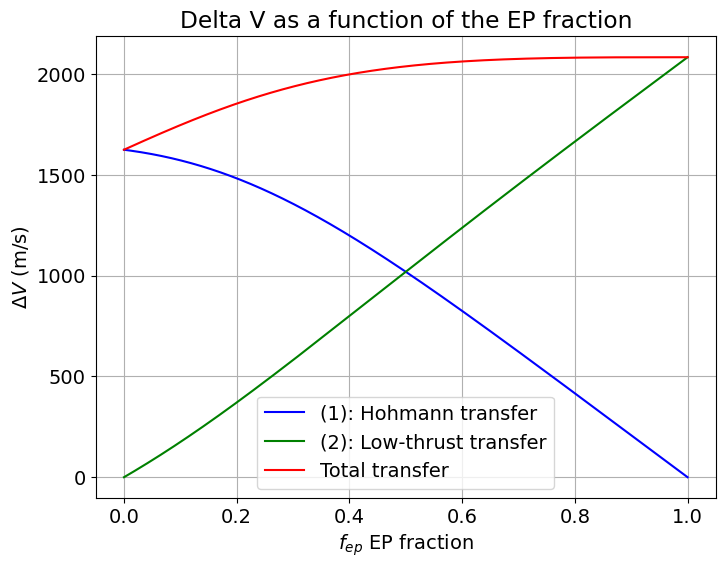

In [7]:
plt.figure(figsize=(8, 6), dpi=100)
plt.rcParams['font.size'] = 14
plt.plot(ep_fraction_CE,delta_v_hoh_vec_CE,'b',label="(1): Hohmann transfer")
plt.plot(ep_fraction_CE,delta_v_lt_vec_CE,'g',label="(2): Low-thrust transfer")
plt.plot(ep_fraction_CE,total_delv_CE,'r',label="Total transfer")
plt.grid(True)    
plt.title(f"Delta V as a function of the EP fraction")
plt.xlabel("$f_{ep}$ EP fraction")  # Add an x-axis label
plt.ylabel(r"$\Delta V$ (m/s)")
plt.legend(loc='best', fontsize=14)
plt.savefig('figures/delv_CE.png')


### Thrusters characterestics

In [8]:
isp_elec=1640 # in seconds
z=1/10 # isp_chem / isp_elec
isp_chem=z*isp_elec # in seconds

c_elec=9.81*isp_elec # in m/s
c_chem=9.81*isp_chem # in m/s

P=1190 # Input power in Watt
thrust_elec= 68*1e-3 # Thrust of the electric thruster in Newton 
Pjet_elec= 0.50*thrust_elec*c_elec # JEt power of the electric thruster in Watt
eta= Pjet_elec/P # Power efficiency
alpha=0.08 # specific mass

ms=167.7 # Structure mass in kg
m0=366.9 # Total mass in kg

mp_chem_CE=m0*(1-np.exp(-delta_v_hoh_vec_CE/c_chem))
mp_elec_CE=(m0-mp_chem_CE)*(1-np.exp(-delta_v_lt_vec_CE/c_elec))


mdot=2*Pjet_elec/c_elec**2 #mass flow rate
tf_CE=mp_elec_CE/mdot # firing time
vst=np.sqrt(2*eta*tf_CE/alpha)# Characterestic velocity in m/s
a_th=thrust_elec/(m0-mp_chem_CE) #Tangential acceleration in m/s^2

x_CE=c_elec/vst
y_CE=total_delv_CE/c_elec
z=c_chem/c_elec
mps_CE=x_CE**2*mp_elec_CE

H_CE=H_hyb_CE(x_CE,y_CE,z,ep_fraction_CE)


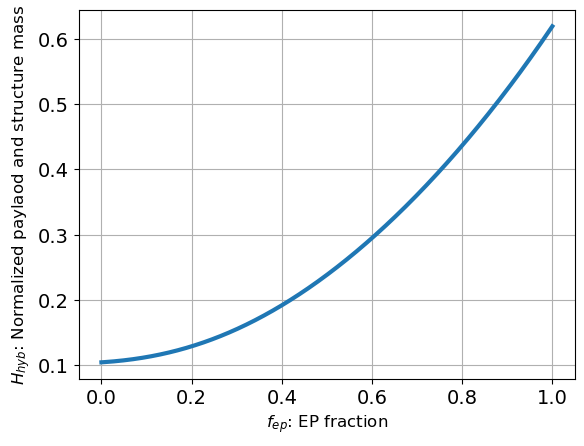

In [9]:
plt.plot(ep_fraction_CE,H_CE,lw=3)
plt.xlabel(r'$f_{ep}$: EP fraction',fontsize=12)  
plt.ylabel(r'$H_{hyb}$: Normalized paylaod and structure mass',fontsize=12)   
plt.grid(True)


### 2- Low-thrust transfer to an intermediate orbit  followed by a Hohmann transfer. 

In [10]:
delta_v_lt_vec_EC= low_thrust_transfer(mu, ri, ai, switch_points, switch_points)
delta_v_hoh_vec_EC= hohmann(mu, switch_points, switch_points, rf,af)

In [11]:
total_delv_EC=delta_v_hoh_vec_EC+delta_v_lt_vec_EC
ep_fraction_EC=delta_v_lt_vec_EC/total_delv_EC

<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
/var/folders/xc/wwmv09fx49ldb0xqhs8v6zsm0000gn/T/ipykernel_82304/3586817074.py:11: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta V$ (m/s)")


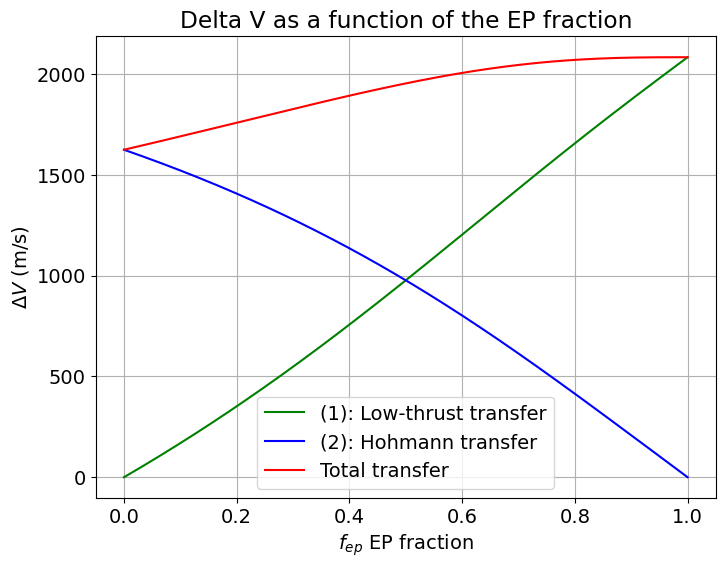

In [12]:
plt.figure(figsize=(8, 6), dpi=100)
plt.rcParams['font.size'] = 14
plt.plot(ep_fraction_EC,delta_v_lt_vec_EC,'g',label="(1): Low-thrust transfer")
plt.plot(ep_fraction_EC,delta_v_hoh_vec_EC,'b',label="(2): Hohmann transfer")
plt.plot(ep_fraction_EC,total_delv_EC,'r',label="Total transfer")


plt.grid(True)    
plt.title(f"Delta V as a function of the EP fraction")
plt.xlabel("$f_{ep}$ EP fraction")  # Add an x-axis label
plt.ylabel("$\Delta V$ (m/s)")
plt.legend(loc='best', fontsize=14)
plt.savefig('figures/delv_EC.png')

In [13]:
mp_elec_EC=m0*(1-np.exp(-delta_v_lt_vec_EC/c_elec))
mp_chem_EC=(m0-mp_elec_EC)*(1-np.exp(-delta_v_hoh_vec_EC/c_chem))

In [14]:
mdot=2*Pjet_elec/c_elec**2 #mass flow rate
tf_EC=mp_elec_EC/mdot # firing time
vst=np.sqrt(2*eta*tf_EC/alpha)# Characterestic velocity in m/s
a_th=thrust_elec/m0 #Tangential acceleration in m/s^2
x_EC=c_elec/vst
y_EC=total_delv_EC/c_elec
mps_EC=x_EC**2*mp_elec_EC

H_EC=H_hyb_EC(x_EC,y_EC,z,ep_fraction_EC)

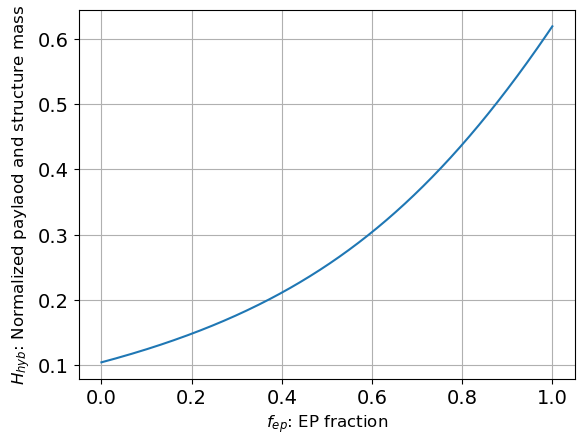

In [15]:
plt.plot(ep_fraction_EC,H_EC)
plt.xlabel(r'$f_{ep}$: EP fraction',fontsize=12)  
plt.ylabel(r'$H_{hyb}$: Normalized paylaod and structure mass',fontsize=12)   
plt.grid(True)

_____

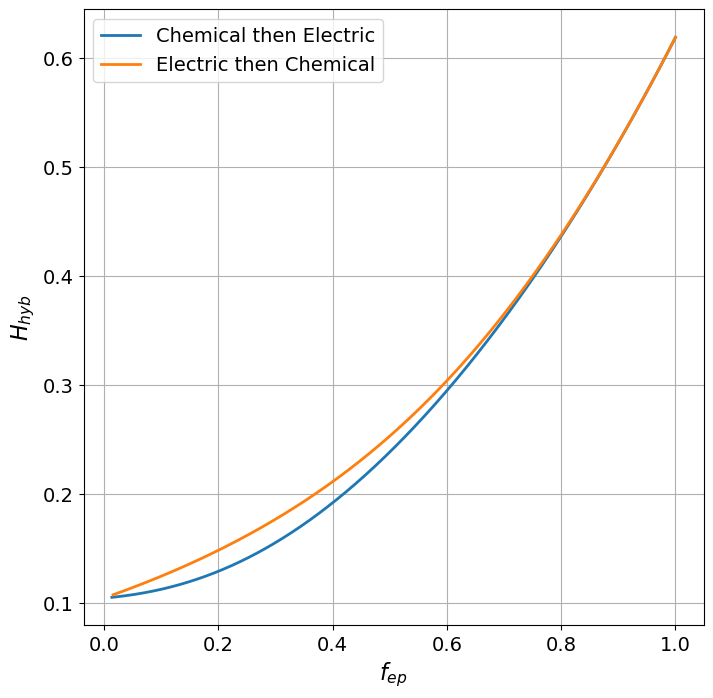

In [16]:
plt.figure(figsize=(8,8))
plt.plot(ep_fraction_CE[:-50],H_CE[:-50],'-',linewidth=2,label="Chemical then Electric")
plt.plot(ep_fraction_EC[2:],H_EC[2:],"-",linewidth=2,label="Electric then Chemical")
plt.xlabel(r'$f_{ep}$',fontsize=16)  
plt.ylabel(r'$H_{hyb}$',fontsize=16)   
#plt.ylim([0.5,0.65])
plt.legend(loc='best', fontsize=14)
plt.grid(True)
#plt.savefig('figures/H_vs_fep.png')


### Time considerations

In [17]:
t_hoh_CE= hohmann_transfer_time(ri, switch_points, mu) # Hohmann transfer time in seconds
t_hoh_EC= hohmann_transfer_time(switch_points,rf, mu) # Hohmann transfer time in seconds

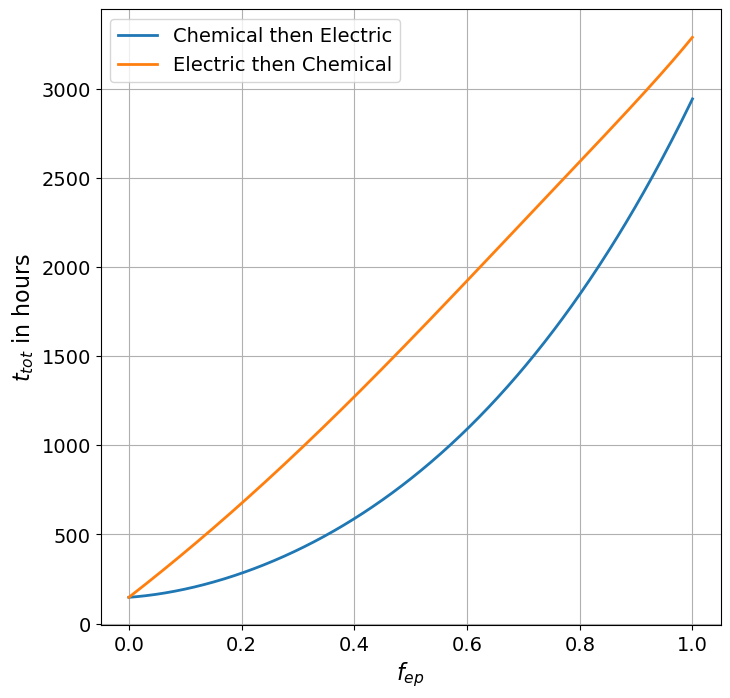

In [18]:
t_CE= t_hoh_CE+ tf_CE 
t_EC= t_hoh_EC+ tf_EC 

plt.figure(figsize=(8,8))
plt.plot(ep_fraction_CE,t_CE/3600,'-',linewidth=2,label="Chemical then Electric")
plt.plot(ep_fraction_EC[:-1],t_EC[:-1]/3600,'-',linewidth=2,label="Electric then Chemical")
plt.xlabel(r'$f_{ep}$',fontsize=16)  
plt.ylabel(r'$t_{tot}$ in hours',fontsize=16) 
#plt.ylim([0,132])
plt.legend(loc='best', fontsize=14)
plt.grid(True)
plt.savefig('figures/time_vs_fep.png')

In [19]:
mpay_CE=m0*H_CE-ms
mpay_EC=m0*H_EC-ms

In [20]:
np.min(mpay_EC)

-129.2830910527899

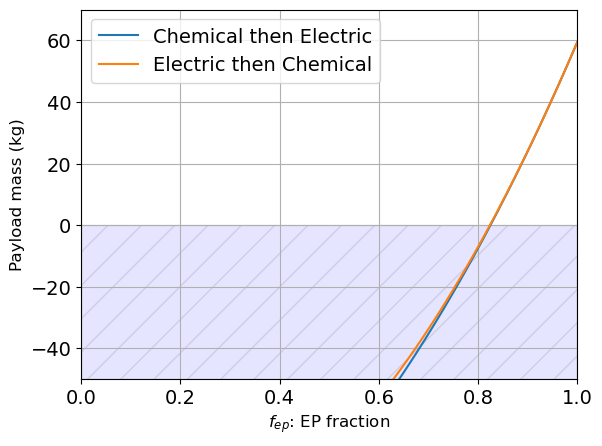

In [21]:
plt.plot(ep_fraction_CE,mpay_CE,'-',label="Chemical then Electric")
plt.plot(ep_fraction_EC[:-1],mpay_EC[:-1],'-',label="Electric then Chemical")

plt.xlabel(r'$f_{ep}$: EP fraction',fontsize=12)  
plt.ylabel(r'Payload mass (kg)',fontsize=12) 
plt.legend(loc='best', fontsize=14)

aa=np.array([-50,-50])
plt.fill_between(np.array([0,1]), aa, where=(aa < 0), color='blue', edgecolor='black', hatch='/', interpolate=True, alpha=0.1)
plt.xlim([0,1])
plt.ylim([-50,70])

plt.grid(True)


(-1.0, 1.0)

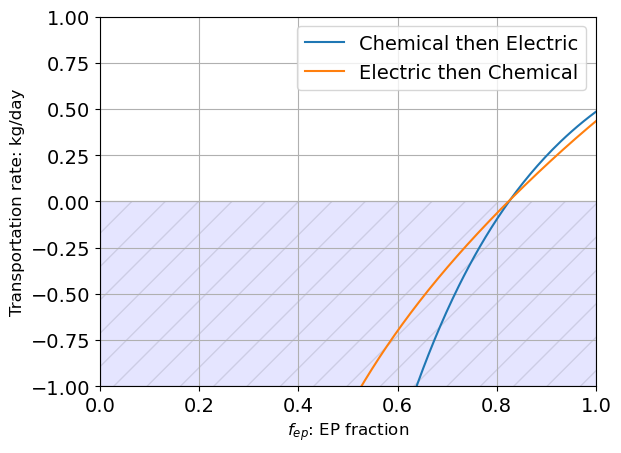

In [22]:

plt.plot(ep_fraction_CE,(m0*H_CE-ms)/(t_CE/3600/24),'-',label="Chemical then Electric")
plt.plot(ep_fraction_EC[:-1],(m0*H_EC[:-1]-ms)/(t_EC[:-1]/3600/24),'-',label="Electric then Chemical")

plt.xlabel(r'$f_{ep}$: EP fraction',fontsize=12)  
plt.ylabel(r'Transportation rate: kg/day',fontsize=12) 
plt.legend(loc='best', fontsize=14)
plt.grid(True)
aa=np.array([-1,-1])
plt.fill_between(np.array([0,1]), aa, where=(aa < 0), color='blue', edgecolor='black', hatch='/', interpolate=True, alpha=0.1)
plt.xlim([0,1])
plt.ylim([-1,1])
#plt.savefig('figures/transportation_rate.png')

### Vary $z=c_{chem}/c_{elec}$

In [23]:
isp_data=(24,1000),(33,1820),(66,2000),(235,600),(71,212),(235,1500),(235,264),(226,780),(235,2200),(262,1733),(283,300),(200,300)
thrust_data=(60,0.3),(35,281),(930,0.5),(22000,110),(370,113),(np.nan,2),(np.nan,5),(1000,0.5),(np.nan,1000),(1430,278),(0.35,0.90),(300,0.58)
Pel_in_data= 40,4500,20,1000,249,100,250,18.4,15900,5400,38,20 #Watt
Pjet_elec_data=1/2*9.81/1000*np.array(isp_data)[:,1]*np.array(thrust_data)[:,1] #Watt 
eta_data=Pjet_elec_data/Pel_in_data

labels = [
    "(1) Cold Gas – Ion Thruster",
    "(2) Cold Gas – Hall Thruster",
    "(3) Cold Gas – Electrospray",
    "(4) Monoprop – Arcjet",
    "(5) Monoprop – Plasma Heating",
    "(6) Monoprop – Helicon Double-Layer Thruster",
    "(7) Monoprop – Microwave Electrochemical Thruster",
    "(8) Monoprop – Electrospray",
    "(9) Monoprop – Pulsed Inductive Thruster",
    "(10) Monoprop – Field Reversed Configuration",
    "(11) Monoprop – Pulsed Plasma Thruster",
    "(12) Solid Prop – Pulsed Plasma Thruster"
]

In [24]:
m0=1000 # Total mass in kg
alpha=0.08

ratio_ps_min=0.05 #m_ps=ratio_ps*m0
ratio_ps_max=0.40 #m_ps=ratio_ps*m0

P_in_min=ratio_ps_min/alpha *m0
P_in_max=ratio_ps_max/alpha *m0


indices = np.where((np.array(Pel_in_data) >= P_in_min) & (np.array(Pel_in_data) <= P_in_max))[0]
indices


array([1, 3])

In [25]:
print(P_in_min)
print(P_in_max)

625.0
5000.0


0.5298076016447517
0.6217983703191652


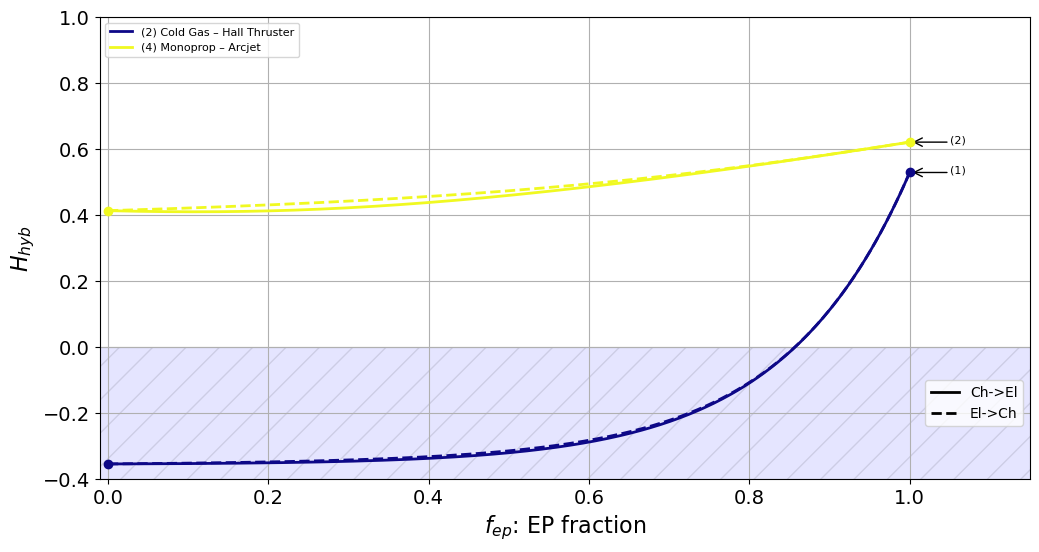

In [26]:
selected_isp_data = [isp_data[i] for i in indices]
selected_Pjet = [Pjet_elec_data[i] for i in indices]
selected_eta = [eta_data[i] for i in indices]
selected_systems = [labels[i] for i in indices]

 # specific mass
colors = cm.plasma(np.linspace(0, 1, len(indices)))

idx=0
plt.figure(figsize=(12,6))
for isp_chem,isp_elec in selected_isp_data:
    
    eta=selected_eta[idx]
    Pjet_elec=selected_Pjet[idx]

    c_elec=9.81*isp_elec # in m/s
    c_chem=9.81*isp_chem # in m/s
    z=c_chem/c_elec
    
    ## Chemical calculations
    mp_chem_CE=m0*(1-np.exp(-delta_v_hoh_vec_CE/c_chem))
    mp_elec_CE=(m0-mp_chem_CE)*(1-np.exp(-delta_v_lt_vec_CE/c_elec))
    
    mdot=2*Pjet_elec/c_elec**2 #mass flow rate
    tf_CE=mp_elec_CE/mdot # firing time
    vst=np.sqrt(2*eta*tf_CE/alpha)# Characterestic velocity in m/s
    x_CE=c_elec/vst
    y_CE=total_delv_CE/c_elec
    
    
    H_CE_varyz=H_hyb_CE(x_CE,y_CE,z,ep_fraction_CE)
    
    

    print(H_CE_varyz[0])

    ## Electric calculations
    mp_elec_EC=m0*(1-np.exp(-delta_v_lt_vec_EC/c_elec))
    mp_chem_EC=(m0-mp_elec_EC)*(1-np.exp(-delta_v_hoh_vec_EC/c_chem))
    tf_EC=mp_elec_EC/mdot # firing time
    vst=np.sqrt(2*eta*tf_EC/alpha)# Characterestic velocity in m/s
    a_th=thrust_elec/m0 #Tangential acceleration in m/s^2
    x_EC=c_elec/vst
    y_EC=total_delv_EC/c_elec
    mps_EC=x_EC**2*mp_elec_EC
    H_EC_varyz=H_hyb_EC(x_EC,y_EC,z,ep_fraction_EC)
    
    ## Plots
    
    plt.plot(ep_fraction_CE, H_CE_varyz,"-", lw=2, color=colors[idx],label=selected_systems[idx])
    plt.plot(ep_fraction_EC, H_EC_varyz,"--" ,lw=2, color=colors[idx])
    
    plt.plot(ep_fraction_CE[-2], H_CE_varyz[-2],"o", color=colors[idx])
    plt.plot(ep_fraction_CE[0], H_CE_varyz[0],"o", color=colors[idx])
    
    
    
    # Add the double arrow at a specific location
    start_point = (1, H_CE_varyz[0])  # Set the start point of the double arrow
    end_point = (1.05, H_CE_varyz[0])    # Set the end point of the double arrow
    arrow = FancyArrowPatch(start_point, end_point, arrowstyle='<-',lw=1, mutation_scale=15, color='k')
    plt.gca().add_patch(arrow)
    #plt.text(1.11, H_CE_varyz[0]-0.01, rf"({isp_chem},{isp_elec}),{eta:.2f}", ha='center', va='bottom', color='k', fontsize=8)
    plt.text(1.06, H_CE_varyz[0]-0.01, rf"({idx+1})", ha='center', va='bottom', color='k', fontsize=8)
    
    
    
    idx=idx+1
    

# Creating legend for line styles
solid_line = Line2D([0], [0], color='black', lw=2, label="Ch->El")
dashed_line = Line2D([0], [0], linestyle="--", color='black', lw=2, label="El->Ch")

# First, create the legend for the z-values
z_legend = plt.legend(loc="upper left",fontsize=8)  # Adjust location as needed
plt.gca().add_artist(z_legend)  # Manually add the first legend

# Now, add the legend for line styles
plt.legend(handles=[solid_line, dashed_line], loc="lower right",fontsize=10,bbox_to_anchor=(1, 0.1))  


plt.xlabel(r'$f_{ep}$: EP fraction',fontsize=16)  
plt.ylabel(r'$H_{hyb}$',fontsize=16)   
plt.grid(True)

aa=np.array([-1,-1])
plt.fill_between(np.array([-0.55,1.5]), aa, where=(aa < 0), color='blue', edgecolor='black', hatch='/', interpolate=True, alpha=0.1)

plt.xlim([-0.01,1.15])
plt.ylim([-0.4,1])
plt.savefig("figures/hybrid/H_hyb.png",bbox_inches='tight')

## Data from the database

In [27]:
import pandas as pd

In [28]:
# Electric propulsion thruster data 
# Filter : 625<P_in<5000

electric_thrusters = [
    {
        "Thruster Name": "Halo12",
        "Type": "Electric",
        "Propellant": "xenon, krypton",
        "Developer": "Exoterra",
        "TRL": "TRL 7",
        "ISP (s)": 1200.0,
        "Thrust (N)": 0.068,
        "Total Power (W)": 1110.0,
        "Thrust/Power (N/kW)": 0.06126,
        "Efficiency": 0.36,
        "Mass (kg)": None
    },
    {
        "Thruster Name": "Medium Power Hall Thruster",
        "Type": "Electric",
        "Propellant": "xenon",
        "Developer": "Shanghai Academy of Spaceflight",
        "TRL": "TRL 5-7*",
        "ISP (s)": 1600.0,
        "Thrust (N)": 0.04,
        "Total Power (W)": 640.0,
        "Thrust/Power (N/kW)": 0.062,
        "Efficiency": 0.48,
        "Mass (kg)": None
    },
    {
        "Thruster Name": "RIT_10_EVO",
        "Type": "Electric",
        "Propellant": "xenon",
        "Developer": "Ariane Group",
        "TRL": "TRL 7-8",
        "ISP (s)": 3200.0,
        "Thrust (N)": 0.025,
        "Total Power (W)": 760.0,
        "Thrust/Power (N/kW)": 0.0329,
        "Efficiency": 0.516,
        "Mass (kg)": None
    },
    {
        "Thruster Name": "SSEP_H71M",
        "Type": "Electric",
        "Propellant": "xenon",
        "Developer": "NASA",
        "TRL": "TRL 3-4",
        "ISP (s)": 1700.0,
        "Thrust (N)": 0.05,
        "Total Power (W)": 1000.0,
        "Thrust/Power (N/kW)": 0.05,
        "Efficiency": 0.42,
        "Mass (kg)": None
    }
]



# Chemical propulsion thruster data
chemical_thrusters = [
    {
        "Thruster Name": "10N Bi-Propellant",
        "Type": "Chemical",
        "Propellant": "hydrazine, MMH, MON-1, MON-3",
        "Developer": "Ariane Group",
        "TRL": "TRL 8",
        "ISP (s)": 292.0,
        "Thrust (N)": 10.0,
        "Total Power (W)": None,
        "Thrust/Power (N/kW)": None,
        "Efficiency": None,
        "Mass (kg)": 0.35
    },
    {
        "Thruster Name": "DST-13",
        "Type": "Chemical",
        "Propellant": "MMH",
        "Developer": "Moog",
        "TRL": "TRL 8",
        "ISP (s)": 298.0,
        "Thrust (N)": 22.0,
        "Total Power (W)": 41.0,
        "Thrust/Power (N/kW)": None,
        "Efficiency": None,
        "Mass (kg)": None
    },
    {
        "Thruster Name": "Stellar SR-5B",
        "Type": "Chemical",
        "Propellant": "hydrazine",
        "Developer": "Stellar",
        "TRL": "TRL 4-5",
        "ISP (s)": 288.0,
        "Thrust (N)": 5.0,
        "Total Power (W)": None,
        "Thrust/Power (N/kW)": None,
        "Efficiency": None,
        "Mass (kg)": None
    },
    {
        "Thruster Name": "TALOS ACS",
        "Type": "Chemical",
        "Propellant": "MMH, MOM",
        "Developer": "Frontier Aerospace",
        "TRL": "TRL 4",
        "ISP (s)": 300.0,
        "Thrust (N)": 45.0,
        "Total Power (W)": None,
        "Thrust/Power (N/kW)": None,
        "Efficiency": None,
        "Mass (kg)": None
    }
]




electric_df = pd.DataFrame(electric_thrusters)
chemical_df = pd.DataFrame(chemical_thrusters)




In [29]:
electric_df

,Thruster Name,Type,Propellant,Developer,TRL,ISP (s),Thrust (N),Total Power (W),Thrust/Power (N/kW),Efficiency,Mass (kg)
0,Halo12,Electric,"xenon, krypton",Exoterra,TRL 7,1200.0,0.068,1110.0,0.06126,0.360,None
1,Medium Power Hall Thruster,Electric,xenon,Shanghai Academy of Spaceflight,TRL 5-7*,1600.0,0.040,640.0,0.06200,0.480,None
2,RIT_10_EVO,Electric,xenon,Ariane Group,TRL 7-8,3200.0,0.025,760.0,0.03290,0.516,None
3,SSEP_H71M,Electric,xenon,NASA,TRL 3-4,1700.0,0.050,1000.0,0.05000,0.420,None


In [30]:
chemical_df

,Thruster Name,Type,Propellant,Developer,TRL,ISP (s),Thrust (N),Total Power (W),Thrust/Power (N/kW),Efficiency,Mass (kg)
0,10N Bi-Propellant,Chemical,"hydrazine, MMH, MON-1, MON-3",Ariane Group,TRL 8,292.0,10.0,NaN,None,None,0.35
1,DST-13,Chemical,MMH,Moog,TRL 8,298.0,22.0,41.0,None,None,NaN
2,Stellar SR-5B,Chemical,hydrazine,Stellar,TRL 4-5,288.0,5.0,NaN,None,None,NaN
3,TALOS ACS,Chemical,"MMH, MOM",Frontier Aerospace,TRL 4,300.0,45.0,NaN,None,None,NaN


In [86]:
isp_elec_data=np.array(electric_df["ISP (s)"])
eta_data=np.array(electric_df["Efficiency"])
Pin_data=np.array(electric_df["Total Power (W)"])
c_elec_data=9.81*isp_elec_data
Pjet_data=eta_data*Pin_data


isp_chem_data=np.array(chemical_df["ISP (s)"])
c_chem_data=9.81*isp_chem_data

In [87]:
labels=chemical_df["Thruster Name"]

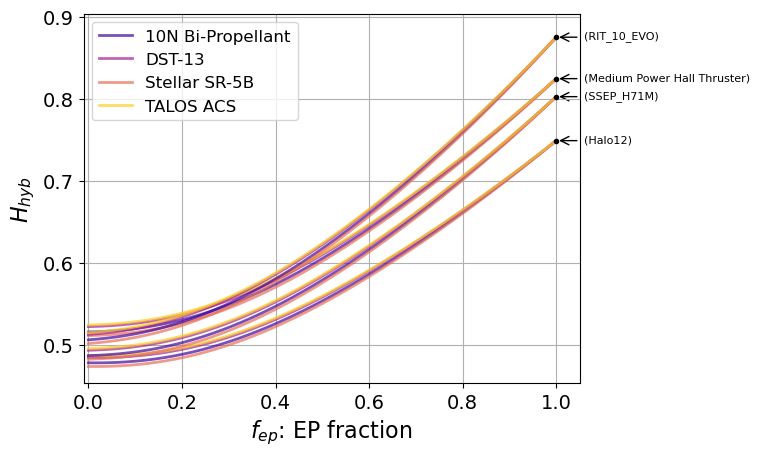

In [89]:
colors = cm.plasma(np.linspace(0.1,0.9, len(c_chem_data)))

idx=0
for c_elec, eta, Pjet in zip(c_elec_data[0:4], eta_data[0:4], Pjet_data[0:4]):
    idx2=0
    for c_chem in c_chem_data[0:4]:
        z=c_chem/c_elec
        
        ## Chemical calculations
        mp_chem_CE=m0*(1-np.exp(-delta_v_hoh_vec_CE/c_chem))
        mp_elec_CE=(m0-mp_chem_CE)*(1-np.exp(-delta_v_lt_vec_CE/c_elec))
        
        mdot=2*Pjet/c_elec**2 #mass flow rate
        tf_CE=mp_elec_CE/mdot # firing time
        vst=np.sqrt(2*eta*tf_CE/alpha)# Characterestic velocity in m/s
        x_CE=c_elec/vst
        y_CE=total_delv_CE/c_elec
        
        H_CE_varyz=H_hyb_CE(x_CE,y_CE,z,ep_fraction_CE)
        
        
        plt.plot(ep_fraction_CE, H_CE_varyz,"-", color=colors[idx2],lw=2,alpha=0.7,label=labels[idx2])
        
        idx2=idx2+1
        
        #plt.plot(ep_fraction_CE[-2], H_CE_varyz[-2],"ko",markersize=3)
        
  
    plt.plot(ep_fraction_CE[0], H_CE_varyz[0],"ko",markersize=3)
    
     # Add the double arrow at a specific location
    start_point = (1, H_CE_varyz[0])  # Set the start point of the double arrow
    end_point = (1.05, H_CE_varyz[0])    # Set the end point of the double arrow
    arrow = FancyArrowPatch(start_point, end_point, arrowstyle='<-',lw=1, mutation_scale=15, color='k')
    plt.gca().add_patch(arrow)
    #plt.text(1.11, H_CE_varyz[0]-0.01, rf"({isp_chem},{isp_elec}),{eta:.2f}", ha='center', va='bottom', color='k', fontsize=8)
    plt.text(1.06, H_CE_varyz[0]-0.005, rf"({electric_df["Thruster Name"][idx]})", ha='left', va='bottom', color='k', fontsize=8)
    
    idx=idx+1
    

# Creating legend for line styles
solid_line = Line2D([0], [0], color='black', lw=2, label="Ch->El")
dashed_line = Line2D([0], [0], linestyle="--", color='black', lw=2, label="El->Ch")



plt.xlabel(r'$f_{ep}$: EP fraction',fontsize=16)  
plt.ylabel(r'$H_{hyb}$',fontsize=16)   
plt.grid(True)



plt.xlim([-0.01,1.05])
#plt.ylim([-0.4,1])
# Get all handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Show only the first 4 legends
plt.legend(handles[:4], labels[:4],fontsize=12)
plt.savefig("figures/hybrid/H_hyb.png",bbox_inches='tight')

In [68]:
ms

500.0

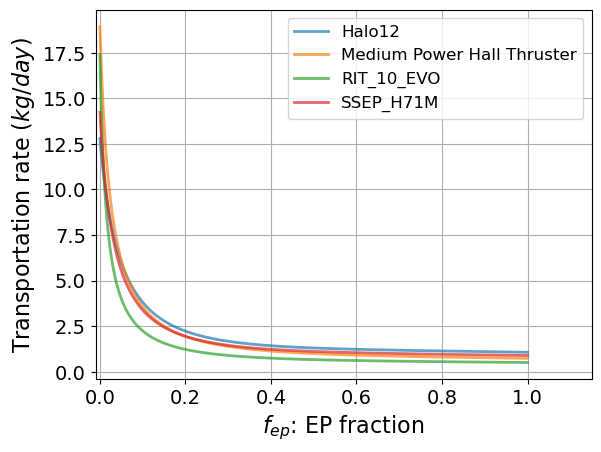

In [93]:
ms=0.4*m0

colors = cm.plasma(np.linspace(0.1,0.9, len(c_chem_data)))

idx=0
for c_elec, eta, Pjet in zip(c_elec_data[0:4], eta_data[0:4], Pjet_data[0:4]):
    idx2=0
    for c_chem in c_chem_data[0:1]:
        z=c_chem/c_elec
        
        ## Chemical calculations
        mp_chem_CE=m0*(1-np.exp(-delta_v_hoh_vec_CE/c_chem))
        mp_elec_CE=(m0-mp_chem_CE)*(1-np.exp(-delta_v_lt_vec_CE/c_elec))
        
        mdot=2*Pjet/c_elec**2 #mass flow rate
        tf_CE=mp_elec_CE/mdot # firing time
        vst=np.sqrt(2*eta*tf_CE/alpha)# Characterestic velocity in m/s
        x_CE=c_elec/vst
        y_CE=total_delv_CE/c_elec
        
        H_CE_varyz=H_hyb_CE(x_CE,y_CE,z,ep_fraction_CE)
        
        t_CE= t_hoh_CE+ tf_CE 
        plt.plot(ep_fraction_CE, (H_CE_varyz*m0-ms)/ (t_CE/3600/24),"-",lw=2,alpha=0.7,label=electric_df["Thruster Name"][idx])
        
        idx2=idx2+1
        
        #plt.plot(ep_fraction_CE[-2], H_CE_varyz[-2],"ko",markersize=3)
    idx=idx+1

    

plt.xlabel(r'$f_{ep}$: EP fraction',fontsize=16)  
plt.ylabel(r'Transportation rate $(kg/day)$',fontsize=16)   
plt.grid(True)



plt.xlim([-0.01,1.15])
#plt.ylim([-0.4,1])
# Get all handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Show only the first 4 legends
plt.legend(fontsize=12)
plt.savefig("figures/hybrid/transportation_rate.png",bbox_inches='tight')
